## This notebook is for testing the SDK before using any scripts for data retrieval / live feed
- Make sure you have the .env file with the corrent variable names listed below before running the code

In [1]:
# Authentication for streaming data
from neurosity import NeurositySDK
from dotenv import load_dotenv
import os

load_dotenv()

neurosity = NeurositySDK({
    "device_id": os.getenv("NEUROSITY_DEVICE_ID")
})

neurosity.login({
    "email": os.getenv("NEUROSITY_EMAIL"),
    "password": os.getenv("NEUROSITY_PASSWORD")
})

In [2]:
# checking the info from the SDK
info = neurosity.get_info()
print(info)

OrderedDict({'channelNames': ['CP6', 'F6', 'C4', 'CP4', 'CP3', 'F5', 'C3', 'CP5'], 'channels': 8, 'deviceId': 'e425ea92bcd7bdae65a5c2b07322433d', 'deviceNickname': 'Emulator-E42', 'emulator': True, 'manufacturer': 'Neurosity, Inc', 'model': 'Emulator 2', 'modelName': 'Emulator', 'modelVersion': '2', 'osVersion': '14.5.0', 'samplingRate': 250})


# Raw Brainwaves Data

In [3]:
# Retrieving raw brainwaves and storing 1 epoch
import time
sample = 0

def callback(data):
    global sample
    sample = data
    
unsubscribe = neurosity.brainwaves_raw(callback) # the function returned from calling the api is used to stop the data feed

time.sleep(1)

unsubscribe()

In [4]:
import matplotlib.pyplot as plt
import numpy as np
# What one epoch looks like
# print(sample)

# Storing & Visualizing 
channels = ['CP6', 'F6', 'C4', 'CP4', 'CP3', 'F5', 'C3', 'CP5']
data = np.array(sample['data'])  
print(data)
print(data.shape)
print(sample['info'])

[[ 29.17934895   7.48518072 -18.43991877 -38.03807184 -43.41765897
  -33.2122692  -13.12439528   7.94675646  21.78540194  23.290204
   14.29256664   2.62463282  -4.73960122  -5.86373827  -4.53109512
   -6.40803547 -12.8824716  -19.91849659 -21.90919768 -16.81458361
   -7.25564515   3.28741414  12.42600194  18.02560762  19.70884878]
 [ -8.43715963 -10.50381327  -6.94900629  -0.76316141   5.04980035
    7.94656753   5.00765371  -2.3505483  -10.72293992 -18.41300823
  -23.25094682 -23.95834903 -22.29509547 -19.70177394 -16.65634237
  -15.23414468 -16.27500192 -17.05868593 -14.80539862  -9.11285182
   -1.0922168    6.74234821  10.35228041   9.22668739   8.38853321]
 [ 20.17911428  12.25238849  -0.48953203 -12.26042993 -17.7727902
  -16.99099572 -12.8445774   -7.85550301  -3.2804408   -0.16586374
    0.1791055   -1.85484763  -3.04235449   1.14389948  12.51175385
   26.49515049  32.96747855  25.35297153   7.80083093  -8.87749234
  -13.9410106   -4.44947916  11.99753177  24.57013924  26.57065

### Epoch Structure
-  the data is recieved as 8 rows, with each row being a channel, and each column being 1 timestamp with the duration between each other depending on the`samplingRate` attribute. 
    E.g. `samplingRate = 250` means 250 samples per second, each sample being 4 ms, and each epoch being 100 ms
- The values themselves range from -40 to +32 microvolts

In [5]:
# Accumilating 5 seconds worth of epochs
data = np.zeros((8,1))
def callback(new):
    new = np.array(new['data'])
    global data
    data = np.concatenate((data,new), axis=1)
    
unsubscribe = neurosity.brainwaves_raw(callback) # the function returned from calling the api is used to stop the data feed

time.sleep(5)

unsubscribe()
print(data)
print(data.shape)

[[  0.          -4.21051674  -0.45512071 ... -35.18494604 -27.60296409
  -16.83724632]
 [  0.          -1.22283072   3.39785899 ... -13.34124141 -18.98812854
  -19.40653424]
 [  0.          16.04977024   5.82419209 ...  35.925044    40.13318952
   36.31060158]
 ...
 [  0.          14.73664921   8.44322671 ... -13.70432528 -25.99044403
  -29.15439982]
 [  0.          10.30942248  -6.73315766 ...   4.25048503   4.75278473
    8.29474314]
 [  0.          10.44437816   9.75801053 ... -12.6112556   -1.94767077
   15.20908071]]
(8, 1101)


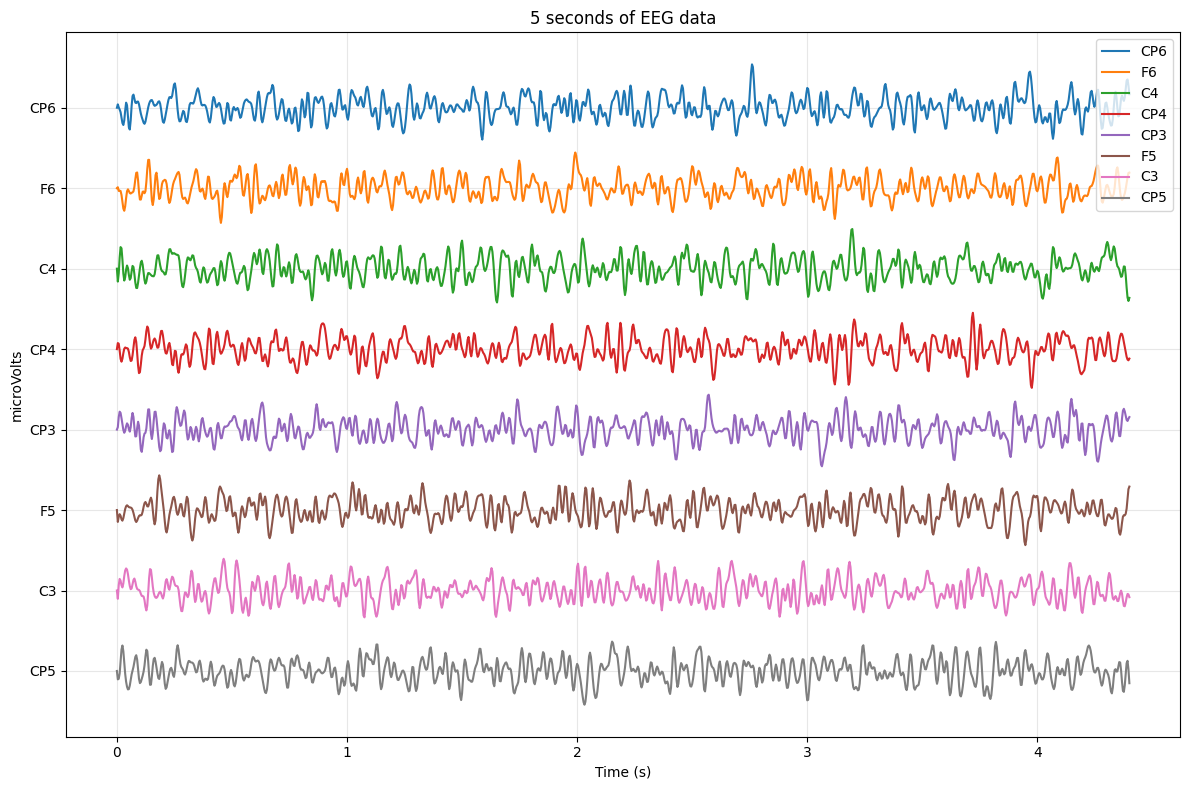

In [6]:
# Visualizing the 5 second window
n_channels, n_samples = data.shape
time = np.arange(n_samples) / 250  # assume 250 Hz sampling rate (adjust!)

plt.figure(figsize=(12, 8))

# Plot each channel with vertical offsets so they don’t overlap
offset = 100  # adjust spacing between signals
for i in range(n_channels):
    plt.plot(time, data[i] + i * offset, label=channels[i])

plt.yticks([i * offset for i in range(n_channels)], channels)
plt.gca().invert_yaxis()

plt.title("5 seconds of EEG data")
plt.xlabel("Time (s)")
plt.ylabel("microVolts")
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

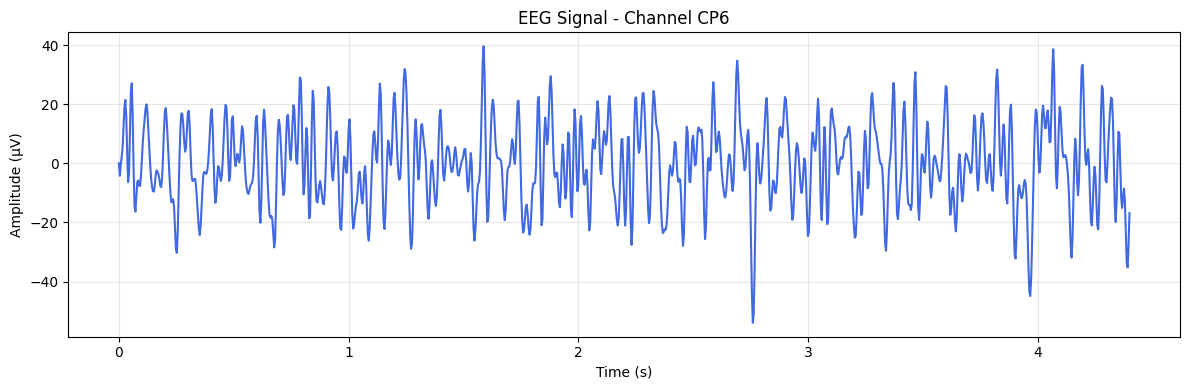

In [7]:
# Visualization for individual channels (e.g. "CP6")
channel_idx = channels.index("CP6")
channel_data = data[channel_idx]

# Sampling rate (adjust to your device)
fs = 250  
time = np.arange(channel_data.shape[0]) / fs

plt.figure(figsize=(12, 4))
plt.plot(time, channel_data, color="royalblue")
plt.title(f"EEG Signal - Channel {channels[channel_idx]}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
